In [1]:
import anndata as ad
import os
import pandas as pd
import scanpy as sc
import subprocess
from scipy import sparse
import numpy as np

portal_obs_fields = [
    'assay',
    'cell_type',
    'development_stage',
    'disease',
    'self_reported_ethnicity',
    'organism',
    'sex',
    'tissue'
]
full_obs_standards = portal_obs_fields + [e + '_ontology_term_id' for e in portal_obs_fields] + ['donor_id','suspension_type','is_primary_data']

In [ ]:
full_obs_standards

We need to load the following libraries. Make sure that the anndata version you have installed matches the one used by [cellxgene-schema](https://github.com/chanzuckerberg/single-cell-curation)

In [2]:
pip show anndata

Name: anndata
Version: 0.8.0
Summary: Annotated data.
Home-page: 
Author: Philipp Angerer, Alex Wolf, Isaac Virshup, Sergei Rybakov
Author-email: 
License: 
Location: /opt/anaconda3/envs/cellxgene/lib/python3.8/site-packages
Requires: h5py, natsort, numpy, packaging, pandas, scipy
Required-by: cellxgene-schema, scanpy
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show cellxgene-schema 


Name: cellxgene-schema
Version: 3.0.1
Summary: Tool for applying and validating cellxgene integration schema to single cell datasets
Home-page: https://github.com/chanzuckerberg/single-cell-curation
Author: Chan Zuckerberg Initiative
Author-email: cellxgene@chanzuckerberg.com
License: MIT
Location: /opt/anaconda3/envs/cellxgene/lib/python3.8/site-packages
Requires: anndata, click, coverage, Cython, numpy, owlready2, pandas, pytest, PyYaml, wheel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Loading the AnnData object
**Update the name of the file (without the .h5ad extension)**<br>
*The sample `my_matrix.h5ad` that is in this repo is subsampled from https://cellxgene.cziscience.com/e/f15e263b-6544-46cb-a46e-e33ab7ce8347.cxg/ with some metadata alterations for the purpose of this tutorial*

In [4]:
file = 'lung_5loc_sc_sn_cellxgene_23092022'

**Load the AnnData object**

In [5]:
adata = sc.read_h5ad(file + '.h5ad')
adata.raw.X 

<193108x20922 sparse matrix of type '<class 'numpy.float32'>'
	with 277931444 stored elements in Compressed Sparse Row format>

# data layers
**If needed, transfer to sparse matrix format, this saves space**

count_nonzero = counts the number of non-zero values in the array 

In [6]:
def determine_sparsity(x):
    if isinstance(x, sparse.coo_matrix) or isinstance(x, sparse.csr_matrix) or isinstance(x, sparse.csc.csc_matrix):
        sparsity = 1 - x.count_nonzero() / float(np.cumprod(x.shape)[-1])
    elif isinstance(x, np.ndarray):
        sparsity = 1 - np.count_nonzero(x) / float(np.cumprod(x.shape)[-1])
    else:
        print(f'matrix is of type {type(x)}, sparsity calculation has not been implemented')

    return sparsity


max_sparsity = 0.5

sparsity = determine_sparsity(adata.X)
print(f'X sparsity: {sparsity}')
if sparsity > max_sparsity and type(adata.X) != sparse.csr.csr_matrix:
    print('converting X to sparse')
    adata.X = sparse.csr_matrix(adata.X)

if adata.raw:
    sparsity = determine_sparsity(adata.raw.X)
    print(f'raw.X sparsity: {sparsity}')
    if sparsity > max_sparsity and type(adata.raw.X) != sparse.csr.csr_matrix:
        print('converting raw.X to sparse')
        raw_adata = ad.AnnData(adata.raw.X, var=adata.raw.var, obs=adata.obs)
        raw_adata.X = sparse.csr_matrix(raw_adata.X)
        adata.raw = raw_adata
        del raw_adata

for l in adata.layers:
    sparsity = determine_sparsity(adata.layers[l])
    print(f'layers[{l}] sparsity: {sparsity}')
    if sparsity > max_sparsity and type(adata.layers[l]) != sparse.csr.csr_matrix:
        print(f'converting layers[{l}] to sparse')
        adata.layers[l] = sparse.csr_matrix(adata.layers[l])

/var/folders/4r/275m7hv11jv8zl5946vzl1c00000gp/T/ipykernel_78384/963552313.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(x, sparse.coo_matrix) or isinstance(x, sparse.csr_matrix) or isinstance(x, sparse.csc.csc_matrix):


X sparsity: 0.0
raw.X sparsity: 0.9312085885799986


/var/folders/4r/275m7hv11jv8zl5946vzl1c00000gp/T/ipykernel_78384/963552313.py:23: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if sparsity > max_sparsity and type(adata.raw.X) != sparse.csr.csr_matrix:


**Check the min/max of each layer**<br>
*Look for duplicated or other unnecessary layers*<br>
*Raw should be whole, positive, ~10<sup>3*

In [7]:
if adata.raw:
    print('raw min = ' + str(adata.raw.X.min()))
    print('raw max = ' + str(adata.raw.X.max()))
    non_integer = np.any(~np.equal(np.mod(adata.raw.X.data, 1), 0))
else:
    non_integer = np.any(~np.equal(np.mod(adata.X.data, 1), 0))

if non_integer == False:
    print('raw is all integers')
else:
    print('ERROR: raw contains non-integer values')

print('X min = ' + str(adata.X.min()))
print('X max = ' + str(adata.X.max()))

for l in adata.layers:
    print(f'layers[{l}] min = ' + str(adata.layers[l].min()))
    print(f'layers[{l}] max = ' + str(adata.layers[l].max()))

raw min = 0.0
raw max = 9.026224
ERROR: raw contains non-integer values
X min = -7.6582603
X max = 10.0


**Sample:** delete a layer

In [ ]:
del adata.layers['other_raw']

# obsm
**Confirm at least one set of embeddings is present**

In [8]:
adata.obsm

AxisArrays with keys: X_pca, X_pca_hm, X_umap, X_umap_BBKNN_scDonor_snBatch, X_umap_Harmony_Donor_n_Material, X_umap_Harmony_Material, X_umap_Harmony_scDonor_snBatch

**View embeddings to identify which matches paper figures**

KeyError: 'Celltypes_colors'

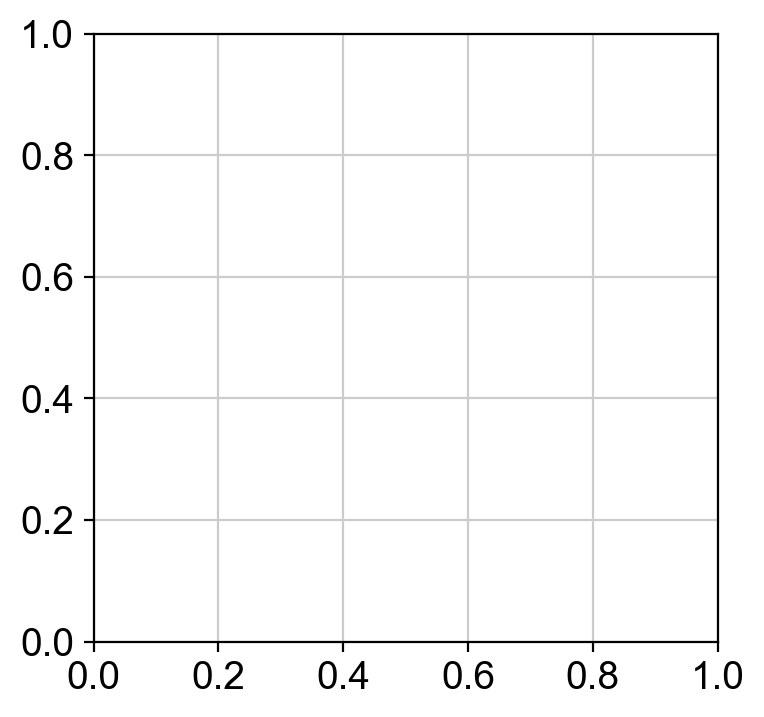

In [9]:
sc.set_figure_params(dpi=100)
for e in adata.obsm:
    sc.pl.embedding(adata, basis=e, color='Celltypes_colors', legend_loc='on data')

**Check that the default_embedding value, if defined, is in obsm**

In [10]:
if 'default_embedding' in adata.uns:
    de = adata.uns['default_embedding']
    if de not in adata.obsm_keys():
        print('ERROR:' + de + ' not in ' + ','.join(adata.obsm_keys()))
    else:
        print(de + ' is in ' + ','.join(adata.obsm_keys()))

**Sample:** update uns.default_embedding\
Ideally, the default_embedding matches the figures in the paper

In [ ]:
adata.uns['default_embedding'] = 'X_umap'

In [11]:
adata.uns

OverloadedDict, wrapping:
	{'Celltypes_colors': array(['#43cd80', '#54ff9f', '#cd6600', '#ff8c00', '#ff83fa', '#9400d3',
       '#ff34b3', '#6e8b3d', '#4169e1', '#add8e6', '#0000ee', '#009acd',
       '#2f4f4f', '#00868b', '#00cdcd', '#8b3626', '#ffbbff', '#ffaeb9',
       '#c71585', '#ee7621', '#ff6347', '#d02090', '#7cfc00', '#c0ff3e',
       '#ffd39b', '#ff7256', '#cd3333', '#cd661d', '#8b4513', '#db7093',
       '#cd919e', '#ff0000', '#388e8e', '#7d9ec0', '#bc8f8f', '#ffdead',
       '#e3a869', '#cd69c9', '#bcee68', '#473c8b', '#00bfff', '#00cd66',
       '#668b8b', '#ee00ee', '#eeaeee', '#68228b', '#87cefa', '#53868b',
       '#ff69b4', '#9a32cd', '#ffd700', '#ff00ff', '#ffa54f', '#ff9912',
       '#ffd39b', '#cdcd00', '#ffa500', '#ffec8b', '#00c957', '#daa520',
       '#8b6914', '#006400', '#8b4c39', '#fa8072', '#97ffff', '#7fffd4',
       '#79cdcd', '#00c78c', '#7fff00', '#173e17', '#8fbc8f', '#c1ffc1',
       '#228b22', '#8b8b00', '#cdcd00', '#ff7256', '#ffa07a', '#a2cd5a',
   

# uns
**Check for uns schema fields**

In [12]:
uns_schema =['schema_version','title']
for p in uns_schema:
    print(p + ': ' + adata.uns.get(p,'MISSING'))

schema_version: MISSING
title: MISSING


**Sample:** define uns.schema_version

In [13]:
adata.uns['schema_version'] = '3.0.0'

In [14]:
adata.uns['title'] = 'hello'

**Browse all of uns**

In [15]:
adata.uns

OverloadedDict, wrapping:
	{'Celltypes_colors': array(['#43cd80', '#54ff9f', '#cd6600', '#ff8c00', '#ff83fa', '#9400d3',
       '#ff34b3', '#6e8b3d', '#4169e1', '#add8e6', '#0000ee', '#009acd',
       '#2f4f4f', '#00868b', '#00cdcd', '#8b3626', '#ffbbff', '#ffaeb9',
       '#c71585', '#ee7621', '#ff6347', '#d02090', '#7cfc00', '#c0ff3e',
       '#ffd39b', '#ff7256', '#cd3333', '#cd661d', '#8b4513', '#db7093',
       '#cd919e', '#ff0000', '#388e8e', '#7d9ec0', '#bc8f8f', '#ffdead',
       '#e3a869', '#cd69c9', '#bcee68', '#473c8b', '#00bfff', '#00cd66',
       '#668b8b', '#ee00ee', '#eeaeee', '#68228b', '#87cefa', '#53868b',
       '#ff69b4', '#9a32cd', '#ffd700', '#ff00ff', '#ffa54f', '#ff9912',
       '#ffd39b', '#cdcd00', '#ffa500', '#ffec8b', '#00c957', '#daa520',
       '#8b6914', '#006400', '#8b4c39', '#fa8072', '#97ffff', '#7fffd4',
       '#79cdcd', '#00c78c', '#7fff00', '#173e17', '#8fbc8f', '#c1ffc1',
       '#228b22', '#8b8b00', '#cdcd00', '#ff7256', '#ffa07a', '#a2cd5a',
   

**Sample:** remove deprecated schema field

In [ ]:
del adata.uns['X_normalization']

# *_colors
**scanpy & cellxgene allow for specification of cluster colors when coloring by specific obs fields**<br>
**A list of color codes is specified in `uns.PROP_colors` where `PROP` is an obs field**<br>
**The number of color codes in `uns.PROP_colors` must be at least as long as the number of unique values in `obs.PROP`**<br>
<br>
**Check for _colors fields & ensure each matches a categorical obs field**

In [16]:
numb_types = ['int_', 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64','float_', 'float16', 'float32', 'float64']

for k in adata.uns.keys():
    if k.endswith('_colors'):
        colors = len(adata.uns[k])
        obs_field = k[:-(len('_colors'))]

        if obs_field.endswith('_ontology_term_id'):
            label_field = obs_field[:-17]
            print(f'WARNING: consider copying uns.{k} to uns.{label_field}_colors so palette transfers to CxG viz')

        if obs_field in portal_obs_fields:
            obs_field += '_ontology_term_id'
        if obs_field not in adata.obs.keys():
            print(f'WARNING: {obs_field} not found in obs, consider DELETING or RENAMING uns.{k}')
        else:
            values = len(adata.obs[obs_field].unique())
            if colors < values:
                print(f'ERROR: uns.{k} has only {str(colors)} colors but obs.{obs_field} has {str(values)} values')
            if adata.obs.dtypes[obs_field].name in numb_types:
                print(f'ERROR: uns.{k} is associated with non-categorical {obs_field}')

# obs

In [17]:
adata.obs_keys()

['Celltypes',
 'Celltypes_master_high',
 'Celltypes_master_higher',
 'Celltypes_master_higher_immune',
 'Loc_true',
 'Material',
 'Donor',
 'Donor_ID_2',
 'Gender',
 'Sample',
 'ID',
 'Protocol_plot',
 'Version',
 'Study',
 'PoolDon',
 'DonorPool',
 'scDonor_snBatch',
 'n_genes',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt']

In [18]:
adata.obs

,Celltypes,Celltypes_master_high,Celltypes_master_higher,Celltypes_master_higher_immune,Loc_true,Material,Donor,Donor_ID_2,Gender,Sample,...,Version,Study,PoolDon,DonorPool,scDonor_snBatch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGGTGTGAATA-1-WTDAtest7887999-0,AT1,Epithelia,Epithelia,AT1,d_LowLeftPar,cells,A32,411C,M,WTDAtest7887999,...,10x3prime_v2,dissociation,nan,nan,A32_cells,1943,1943,5356.075684,186.790329,3.487448
AAACGGGCAACCGCCA-1-WTDAtest7887999-0,B_plasma_IgA,Immune,Immune,B_cell,d_LowLeftPar,cells,A32,411C,M,WTDAtest7887999,...,10x3prime_v2,dissociation,nan,nan,A32_cells,226,226,768.994751,5.476773,0.712199
AACCATGGTACAGCAG-1-WTDAtest7887999-0,Monocyte_CD16,Immune,Immune,Monocyte,d_LowLeftPar,cells,A32,411C,M,WTDAtest7887999,...,10x3prime_v2,dissociation,nan,nan,A32_cells,847,847,1901.789185,108.158295,5.687187
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0,CD8_EM/EMRA,Immune,Immune,CD8,d_LowLeftPar,cells,A32,411C,M,WTDAtest7887999,...,10x3prime_v2,dissociation,nan,nan,A32_cells,767,767,1783.324097,85.630554,4.801738
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0,Macro_intravascular,Immune,Immune,Macrophage_other,d_LowLeftPar,cells,A32,411C,M,WTDAtest7887999,...,10x3prime_v2,dissociation,nan,nan,A32_cells,799,799,1314.895386,97.600655,7.422694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1,T_reg,Immune,Immune,CD4,b_Bronchi.2.3,nuclei,A42,nan,nan,WSSS_A_LNG8757929,...,nan,nan,A42,A42none,A42_nuclei,1556,1556,2975.571777,0.000000,0.000000
TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1,SMG_Mucous,Epithelia,Epithelia,Submucosal_Glands,b_Bronchi.2.3,nuclei,A42,nan,nan,WSSS_A_LNG8757929,...,nan,nan,A42,A42none,A42_nuclei,2723,2723,7334.214355,0.000000,0.000000
TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1,Basal,Epithelia,Epithelia,Epi_Basal,b_Bronchi.2.3,nuclei,A42,nan,nan,WSSS_A_LNG8757929,...,nan,nan,A42,A42none,A42_nuclei,500,500,626.389465,0.000000,0.000000
TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1,SMG_Mucous,Epithelia,Epithelia,Submucosal_Glands,b_Bronchi.2.3,nuclei,A42,nan,nan,WSSS_A_LNG8757929,...,nan,nan,A42,A42none,A42_nuclei,2576,2576,6651.600586,0.000000,0.000000


**Ensure the portal fields are not used**<br>
**Ensure schema fields are present and values are valid & precise**

In [19]:
for o in full_obs_standards:
    print(o)
    if o not in adata.obs_keys():
        print('NOT IN OBS')
    else:
        un = adata.obs[o].unique()
        if un.dtype == 'category':
            print(un.to_list())
        else:
            print(un.tolist())

assay
NOT IN OBS
cell_type
NOT IN OBS
development_stage
NOT IN OBS
disease
NOT IN OBS
self_reported_ethnicity
NOT IN OBS
organism
NOT IN OBS
sex
NOT IN OBS
tissue
NOT IN OBS
assay_ontology_term_id
NOT IN OBS
cell_type_ontology_term_id
NOT IN OBS
development_stage_ontology_term_id
NOT IN OBS
disease_ontology_term_id
NOT IN OBS
self_reported_ethnicity_ontology_term_id
NOT IN OBS
organism_ontology_term_id
NOT IN OBS
sex_ontology_term_id
NOT IN OBS
tissue_ontology_term_id
NOT IN OBS
donor_id
NOT IN OBS
suspension_type
NOT IN OBS
is_primary_data
NOT IN OBS


### Prepare the obs layer

First we extract the obs layer from the h5ad file that has been provided to us. Then we extract out the obs layer as a csv file. 



In [ ]:
a_obs = adata.obs
a_obs.to_csv("a_obs_layer.csv")


In [ ]:
r_obs = adata.raw.obs
r_obs.to_csv("r_obs_layer.csv")

Download the excel spreadsheet from the INGEST data submission, and navigate to the sequence_file page.
Select the cell_suspension.biomaterial_core.biomaterial_id, cell_suspension.uuid, and library_preparation_protocol.protocol_core.protocol_id and filter for duplicates on those keys. This results in a unique set of cell_suspensions with their related data. 

See script here: https://github.com/ebi-ait/ingest-cellxgene-submitter#create-obs-layer-from-multiple-cell-suspension-uuids

The manual work here is  matching up unique HCA cell_suspensions and metadata with the  unique samples in the provided-h5ad file. We then generate a final obs_layer.csv which combines HCA metadata with the provided metadata from the contributor in matching rows. There is an opportunity for future automation here for scripts to perform the matching and to provide cell-type ontology terms. 

For a list of fields which should be in the final obs_layer.csv see (https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/2.0.0/schema.md#obs-cell-metadata)
- assay_ontology_term_id
- cell_type_ontology_term_id
- development_stage_ontology_term_id
- disease_ontology_term_id
- ethnicity_ontology_term_id
- is_primary_data
- organism_ontology_term_id
- sex_ontology_term_id
- tissue_ontology_term_id
- donor_id

There is also some manual work here to select cell-type ontology terms from the free text cell-type provided by the contributors. There is an opportunity for future automation here to get scripts / work with other experts in ontology to do this. 

Once we have the final combined obs_layer, then save it as "obs_layer.csv" and save it as a dobs object

In [21]:
dobs = pd.read_csv("a_obs_layer.csv",sep=",")

/var/folders/4r/275m7hv11jv8zl5946vzl1c00000gp/T/ipykernel_78384/3991837842.py:1: DtypeWarning: Columns (11,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  dobs = pd.read_csv("a_obs_layer.csv",sep=",")


,Unnamed: 0,Celltypes,Celltypes_master_high,Celltypes_master_higher,Celltypes_master_higher_immune,Celltypes_master_2,Celltypes_master_3,Loc_true,suspension_type,scsn,...,body_mass_index,is_primary_data,organism_ontology_term_id,sex_ontology_term_id,author_tissue_label,tissue_ontology_term_id,assay_label,assay_ontology_term_id,cell_type_ontology_term_id,cell_type_ontology_term_label
0,AAACCTGGTGTGAATA-1-WTDAtest7887999-0,AT1,AT1,Epithelia,AT1,Epithelia,Epithelia,d_LowLeftPar,cell,cells,...,22.0,True,NCBITaxon:9606,PATO:0000384,Lower Left Lobe,UBERON:0008949,Singlecell_10x3prime_v2,EFO:0009899,CL:0002062,type I pneumocyte
1,AAACGGGCAACCGCCA-1-WTDAtest7887999-0,B_plasma_IgA,B_plasma,Immune,B_cell,Immune,Immune,d_LowLeftPar,cell,cells,...,22.0,True,NCBITaxon:9606,PATO:0000384,Lower Left Lobe,UBERON:0008949,Singlecell_10x3prime_v2,EFO:0009899,CL:0000786,plasma cell
2,AACCATGGTACAGCAG-1-WTDAtest7887999-0,Monocyte_CD16,Myeloid,Immune,Monocyte,Immune,Immune,d_LowLeftPar,cell,cells,...,22.0,True,NCBITaxon:9606,PATO:0000384,Lower Left Lobe,UBERON:0008949,Singlecell_10x3prime_v2,EFO:0009899,CL:0000576,monocyte
3,AACGTTGGTGTCCTCT-1-WTDAtest7887999-0,CD8_EM/EMRA,T_NK,Immune,CD8,Immune,Immune,d_LowLeftPar,cell,cells,...,22.0,True,NCBITaxon:9606,PATO:0000384,Lower Left Lobe,UBERON:0008949,Singlecell_10x3prime_v2,EFO:0009899,CL:0000913,"effector memory CD8-positive, alpha-beta T cell"
4,AACTCCCTCCTAGTGA-1-WTDAtest7887999-0,Macro_int,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cell,cells,...,22.0,True,NCBITaxon:9606,PATO:0000384,Lower Left Lobe,UBERON:0008949,Singlecell_10x3prime_v2,EFO:0009899,CL:1001603,lung macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193103,TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1,T_reg,T_NK,Immune,CD4,Immune,Immune,b_Bronchi.2.3,nucleus,nuclei,...,32.5,True,NCBITaxon:9606,PATO:0000384,Trachea,UBERON:0003126,Singlenuclei_10x3prime_v3,EFO:0009922,CL:0000815,regulatory T cell
193104,TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,b_Bronchi.2.3,nucleus,nuclei,...,32.5,True,NCBITaxon:9606,PATO:0000384,Trachea,UBERON:0003126,Singlenuclei_10x3prime_v3,EFO:0009922,CL:1000272,lung secretory cell
193105,TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1,Basal,Epi_Basal,Epithelia,Epi_Basal,Epithelia,Epithelia,b_Bronchi.2.3,nucleus,nuclei,...,32.5,True,NCBITaxon:9606,PATO:0000384,Trachea,UBERON:0003126,Singlenuclei_10x3prime_v3,EFO:0009922,CL:0000646,basal cell
193106,TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,b_Bronchi.2.3,nucleus,nuclei,...,32.5,True,NCBITaxon:9606,PATO:0000384,Trachea,UBERON:0003126,Singlenuclei_10x3prime_v3,EFO:0009922,CL:1000272,lung secretory cell


In [24]:
for o in full_obs_standards:
    print(o)
    if o not in dobs.keys():
        print('NOT IN OBS')
    else:
        un = dobs[o].unique()
        if un.dtype == 'category':
            print(un.to_list())
        else:
            print(un.tolist())

assay
NOT IN OBS
cell_type
NOT IN OBS
development_stage
NOT IN OBS
disease
NOT IN OBS
self_reported_ethnicity
NOT IN OBS
organism
NOT IN OBS
sex
NOT IN OBS
tissue
NOT IN OBS
assay_ontology_term_id
['EFO:0009899', 'EFO:0011025', 'EFO:0009922']
cell_type_ontology_term_id
['CL:0002062', 'CL:0000786', 'CL:0000576', 'CL:0000913', 'CL:1001603', 'CL:0002063', 'CL:0000583', 'CL:0002503', 'CL:0001065', 'CL:0001054', 'CL:0000623', 'CL:0000940', 'CL:0000815', 'CL:0001044', 'CL:0000909', 'CL:0002138', 'CL:0000071', 'CL:0000451', 'CL:0000897', 'CL:0000898', 'CL:0000097', 'CL:1000272', 'CL:0000646', 'CL:0000067', 'CL:0000158', 'CL:0002591', 'CL:0000787', 'CL:0000798', 'CL:1001568', 'CL:0000186', 'CL:0002553', 'CL:0000160', 'CL:0000057', 'CL:0009089', 'CL:0000232', 'CL:0000788', 'CL:0000082', 'CL:0000077', 'CL:0002539', 'CL:0000556', 'CL:0005006', 'CL:0000125', 'CL:0000165', 'CL:0005012', 'CL:0002376', 'CL:0000138', 'CL:0000218', 'CL:0000185']
development_stage_ontology_term_id
['HsapDv:0000123', 'Hs

In [27]:
adata.obs = dobs

Check here for redundant fields in the obs layer (e.g. tissue_label, donor_ext). Assay_ontology_term_id should be '10x v2 5' sequencing' as opposed to '10x TCR'.
Development_stage and tissue should be made specific (e.g. 35-year old human stage).
Unannotated cells use CL:0000003 (native cell).
Check that certain fields in the obs layer should not be continuous / numerical, but should be categorical or string. Use the cells below to fix this if necessary.

**Sample:** set the index to the "barcodes" column

In [26]:
dobs = dobs.set_index("Unnamed: 0", inplace = False)

**Sample:** drop "author_tissue" and "donor_ext" columns from obs

In [ ]:
adata.obs = adata.obs.drop(['Unnamed: 18','author_tissue','tissue_label','donor_ext'], axis = 1)

**Sample:** set specific obs datatypes to category

In [ ]:
adata.obs = adata.obs.astype({'batch': 'category','cluster':'category'}, copy = False)

**Ensure the portal fields are not used**<br>
**Ensure schema fields are present and values are valid & precise**

In [ ]:
for o in full_obs_standards:
    print(o)
    if o not in adata.obs_keys():
        print('NOT IN OBS')
    else:
        un = adata.obs[o].unique()
        if un.dtype == 'category':
            print(un.to_list())
        else:
            print(un.tolist())

# 10x barcode checker
**Checks a random 1k barcodes against 10x barcode lists**<br>
*Can help confirm 3' v2 vs v3 vs multiome*<br>
*5' v1 and v2 kits use the same barcode list as 3' v2*<br>
*Assumes the barcode is in the index. Suffixes/prefixes are OK*<br>
<br>
**Define the function**

In [28]:
import json
import re
from random import randint


def TENx_barcode_checker(df):
    num_to_check = 1000

    v2_file = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/737K-august-2016.txt'
    v3_file = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/3M-february-2018.txt'
    multiome_file = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/737K-arc-v1.txt'

    v2_list = [line.strip() for line in open(v2_file, 'r')]
    v3_list = [line.strip() for line in open(v3_file, 'r')]
    multiome_list = [line.strip() for line in open(multiome_file, 'r')]

    cellcount = df.index.shape[0]
    barcode_pattern = '[ACTG]{16}'
    barcode_results = ''
    if re.search(barcode_pattern, df.index[5]):
        cellcount
        random_indices = [randint(0, cellcount - 1) for p in range(0, num_to_check)]
        barcodes = {'3pv2_5pv1_5pv2': 0,'3pv3': 0,'multiome': 0,'multiple': 0,'none': 0}
        for i in random_indices:
            if re.search(barcode_pattern, df.index[i]):
                barcode = re.search(barcode_pattern, df.index[i]).group(0)
                if barcode in v2_list:
                    if barcode in multiome_list:
                        barcodes['multiple'] += 1
                    elif barcode in v3_list:
                        barcodes['multiple'] += 1
                    else:
                        barcodes['3pv2_5pv1_5pv2'] += 1
                elif barcode in multiome_list:
                    if barcode in v3_list:
                        barcodes['multiple'] += 1
                    else:
                        barcodes['multiome'] += 1
                elif barcode in v3_list:
                    barcodes['3pv3'] += 1
                else:
                    barcodes['none'] += 1
        return barcodes

**Check 1k barcodes across the whole obs**

In [29]:
results = TENx_barcode_checker(adata.obs)
if not results:
    print('no barcodes checked')
pd.DataFrame([results])

,3pv2_5pv1_5pv2,3pv3,multiome,multiple,none
0,594,328,0,78,0


**Additionally, can check 1k barcodes from multiple subsets of obs**<br>
*Define `prop` and 1k barcodes will be checked for each unique value in `obs.prop`*

In [ ]:
prop = 'assay_ontology_term_id'

results = []
for a in adata.obs[prop].value_counts().keys():
    print(a)
    r = TENx_barcode_checker(adata.obs[adata.obs[prop] == a])
    if r:
        r[prop] = a
        results.append(r)
    else:
        print('no barcodes checked')
pd.DataFrame(results).set_index(prop)

**Sample:** set a column with all the same values

In [ ]:
adata.obs['is_primary_data'] = True
adata.obs['suspension_type'] = 'nucleus'

**Sample:** change column names

In [ ]:
rename_me = {
    'cell_type': 'author_cell_type',
    'ethnicity_ontology_id': 'self_reported_ethnicity_ontology_term_id',
    'disease_ontology_id': 'disease_ontology_term_id'
}

adata.obs.rename(columns=rename_me, inplace=True)

**Sample:** fill null values of a specific column with a specified value

In [ ]:
adata.obs['sex_ontology_term_id'].cat.add_categories('unknown', inplace=True)
adata.obs.fillna({'sex_ontology_term_id': 'unknown'}, inplace=True)
adata.obs['sex_ontology_term_id'].value_counts(dropna=False)

**Sample:** adjust the values in a specific column in a standard way

In [ ]:
def fix_typo(x):
    return x.replace('_',':')


adata.obs['development_stage_ontology_term_id'] = adata.obs['development_stage_ontology_term_id'].apply(fix_typo)
adata.obs['development_stage_ontology_term_id'].value_counts(dropna=False)

**Sample:** replace specified values in specified columns

In [ ]:
replace_me = {
    'organism_ontology_term_id':{'human':'NCBITaxon:9606', 'mouse': 'NCBITaxon:10090'},
    'assay_ontology_term_id': {'EFO:0030003': 'EFO:0009899'}
}

adata.obs.replace(replace_me,inplace=True)
adata.obs[['organism_ontology_term_id','assay_ontology_term_id']].value_counts(dropna=False)

**Sample:** add a new column with values based on values in an existing column - with DataFrame<br>
**Step 1:** get the values to map from

In [ ]:
for k in adata.obs['author_cell_type'].unique():
    print(k)

**Sample:** add a new column with values based on values in an existing column<br>
**Step 2:** set up a dataframe with the mapping
**Option A:** from a dictionary

In [ ]:
#map in values based on another field - step 2: set up a dataframe with the mapping
#option A: from dict
celltypes = {
    'Myeloid': 'CL:0001082',
    'Endothelial': 'CL:0010008',
    'Fibroblast': 'CL:0002548',
    'Cardiomyocyte': 'CL:0000513',
    'Pericyte': 'CL:0000669',
    'Lymphoid': 'CL:0000838',
    'Cycling cells': 'CL:0000003',
    'vSMCs': 'CL:0000514',
    'Neuronal': 'CL:0000006'
}

ct_df = pd.DataFrame.from_dict(celltypes,orient='index',columns=['cell_type_ontology_term_id']).reset_index().rename(columns={'index':'author_cell_type'})
ct_df

**Sample:** add a new column with values based on values in an existing column<br>
**Step 2:** set up a dataframe with the mapping<br>
**Option B:** from a Google Sheet<br>
*Google Sheet permissions must be Anyone with Link is a Viewer*

In [ ]:
sheet_id = '15oG8v5BS6HMPqCehYQcujMZUq9PgQNpo8osKhO7yA5o'
tab_name = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={tab_name}'
ct_df = pd.read_csv(url)
ct_df

**Sample:** add a new column with values based on values in an existing column<br>
**Step 3:** merge the dataframe into obs<br>
*`how='left'` is critical to ensure obs order is retained*<br>
*`set_index` is critical to ensure the index is retained*<br>

In [ ]:
adata.obs = adata.obs.merge(ct_df, on='author_cell_type',how='left').set_index(adata.obs.index)
adata.obs[['author_cell_type','cell_type_ontology_term_id']].value_counts(dropna=False)

**Sample:** add a new column with values based on values in an existing column - with Dictionary<br>

In [ ]:
adata.obs['sample'].value_counts()

In [ ]:
donor_map = {
    'KL001': 'P21',
    'KL002': 'P22',
    'KL003': 'P23'
}

adata.obs['donor_id'] = adata.obs['sample'].map(donor_map)
adata.obs[['donor_id','sample']].value_counts(dropna=False)

**Look for general obs field issues and collect obs information to check for redundant information**

In [ ]:
long_fields = []
gradient_fields = []
uber_dict = {}
for o in adata.obs.keys():
    vc_dict = adata.obs[o].value_counts(dropna=False).to_dict()
    counts = '_'.join([str(c) for c in vc_dict.values()])
    count_len = len(vc_dict.keys())
    values = [str(i) for i in vc_dict.keys()]

    if o.startswith(' ') or o.endswith(' ') or '  ' in o:
        print('leading/trailing whitespace:' + o)

    if o not in full_obs_standards and ' '.join(o.split()).lower() in full_obs_standards:
        print('schema conflict:' + o)

    if count_len == 1:
        lone_v = str(list(vc_dict.keys())[0])
        if o not in full_obs_standards:
            print('all same value:' + o + ',' + lone_v)

    numb_types = ['int_', 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64','float_', 'float16', 'float32', 'float64']
    if adata.obs.dtypes[o].name in numb_types:
        gradient_fields.append(o)
    #check for long categories as they will not be enabled for coloring
    elif count_len > 200:
        long_fields.append(o)

    #report value_counts to later look for redundancy
    metadata = {
        'values': values,
        'property': o
    }
    if counts in uber_dict:
        uber_dict[counts].append(metadata)
    else:
        uber_dict[counts] = [metadata]

**Comb value_counts to report possible redundancy**

In [ ]:
for k,v in uber_dict.items():
    if '_' in k and not k.startswith('1_1'):
        props = [e['property'] for e in v]
        if len(v) > 1 and not all(elem in full_obs_standards for elem in props):
            print('cells breakdown: ' + k)
            for e in v:
                print(e['property'])
                #print(e['values'])
            print('----------------------------------------------------------------------------')

**Investigate any fields that may be redundant**

In [ ]:
adata.obs[['sample','patient','age','development_stage_ontology_term_id']].value_counts(dropna=False)

**Check for fields that aren't appropriate as gradient (e.g. cluster number)**

In [ ]:
gradient_fields

**Update a gradient field to categorical, if needed**

In [ ]:
adata.obs['cluster_id'] = adata.obs['cluster_id'].map(str)

**List any categorical fields with more than 200 categories as they may not be useful in the visualization**

In [ ]:
long_fields

**List any obs columns to remove and remove them**

In [ ]:
obs_remove = [
    'tissue',
    'organism',
    'self_reported_ethnicity',
    'assay',
    'disease',
    'sex',
    'cell_type'
]

obs_remove = [o for o in obs_remove if o in adata.obs.columns]
adata.obs.drop(columns=obs_remove, inplace=True)
if obs_remove:
    print('removed: ' + ','.join(obs_remove))

**Ensure the portal fields are not used**<br>
**Ensure schema fields are present and values are valid & precise**

In [30]:
for o in full_obs_standards:
    print(o)
    if o not in adata.obs_keys():
        print('NOT IN OBS')
    else:
        un = adata.obs[o].unique()
        if un.dtype == 'category':
            print(un.to_list())
        else:
            print(un.tolist())

assay
NOT IN OBS
cell_type
NOT IN OBS
development_stage
NOT IN OBS
disease
NOT IN OBS
self_reported_ethnicity
NOT IN OBS
organism
NOT IN OBS
sex
NOT IN OBS
tissue
NOT IN OBS
assay_ontology_term_id
['EFO:0009899', 'EFO:0011025', 'EFO:0009922']
cell_type_ontology_term_id
['CL:0002062', 'CL:0000786', 'CL:0000576', 'CL:0000913', 'CL:1001603', 'CL:0002063', 'CL:0000583', 'CL:0002503', 'CL:0001065', 'CL:0001054', 'CL:0000623', 'CL:0000940', 'CL:0000815', 'CL:0001044', 'CL:0000909', 'CL:0002138', 'CL:0000071', 'CL:0000451', 'CL:0000897', 'CL:0000898', 'CL:0000097', 'CL:1000272', 'CL:0000646', 'CL:0000067', 'CL:0000158', 'CL:0002591', 'CL:0000787', 'CL:0000798', 'CL:1001568', 'CL:0000186', 'CL:0002553', 'CL:0000160', 'CL:0000057', 'CL:0009089', 'CL:0000232', 'CL:0000788', 'CL:0000082', 'CL:0000077', 'CL:0002539', 'CL:0000556', 'CL:0005006', 'CL:0000125', 'CL:0000165', 'CL:0005012', 'CL:0002376', 'CL:0000138', 'CL:0000218', 'CL:0000185']
development_stage_ontology_term_id
['HsapDv:0000123', 'Hs

In [ ]:
adata.obs

# var
**Check for Ensembl IDs, redundant fields, etc.**<br>
**Check for schema fields**

## Map Gene Symbols to ENSEMBL IDs
**Skip this section if there are already ENSEMBL IDs**

In [31]:
adata.var

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,gene_ids-1,n_cells-1,n_cells_by_counts-1,...,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
HES4,False,HES4,16580,16580,0.302786,88.689619,44385.750000,ENSG00000188290,5369,5369,...,Gene Expression,18879,True,0.348015,2.407703,0.858933,2,True,-4.553251e-11,0.512652
TNFRSF18,False,TNFRSF18,5391,5391,0.055908,96.322421,8195.559570,ENSG00000186891,570,570,...,Gene Expression,5383,True,0.090583,2.411408,0.957952,2,True,-2.240157e-11,0.252654
TNFRSF4,False,TNFRSF4,5113,5113,0.054750,96.512064,8025.812988,ENSG00000186827,521,521,...,Gene Expression,5170,True,0.103728,2.507761,1.110371,2,True,1.818045e-11,0.274860
AL645728.1,False,AL645728.1,1166,1166,0.008344,99.204590,1223.174438,ENSG00000215014,367,367,...,Gene Expression,1251,True,0.020191,2.200457,0.519287,2,True,-9.707694e-12,0.115668
TTC34,False,TTC34,707,707,0.005823,99.517706,853.601624,ENSG00000215912,2557,2557,...,Gene Expression,1571,True,0.040115,2.175078,0.452723,2,True,-1.262883e-11,0.133543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBASH3A,False,UBASH3A,2057,2057,0.015399,98.596776,2257.323975,ENSG00000160185,1330,1330,...,Gene Expression,2619,True,0.076424,2.345723,0.911611,2,True,2.340285e-12,0.203516
RSPH1,False,RSPH1,3765,3765,0.404490,97.431629,59294.632812,ENSG00000160188,3671,3671,...,Gene Expression,5024,True,0.237395,2.757026,1.647012,2,True,-2.383287e-11,0.381427
COL18A1,False,COL18A1,13232,13232,0.149136,90.973525,21861.937500,ENSG00000182871,6512,6512,...,Gene Expression,16562,True,0.321884,2.337140,0.801880,2,True,9.382796e-12,0.458006
COL6A1,False,COL6A1,14127,14127,0.513421,90.362983,75262.882812,ENSG00000142156,10117,10117,...,Gene Expression,19712,True,0.514242,2.488781,0.826094,2,True,-8.717349e-12,0.586709


In [32]:
adata.raw.var

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,gene_ids-1,n_cells-1,n_cells_by_counts-1,...,pct_dropout_by_counts-1,total_counts-1,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
FAM87B,False,FAM87B,176,176,0.001221,99.879938,178.966705,ENSG00000177757,39,39,...,99.966985,37.157669,Gene Expression,196,False,0.001895,1.718146,-0.593497,0,False
LINC00115,False,LINC00115,2468,2468,0.017432,98.316404,2555.424072,ENSG00000225880,911,911,...,99.228803,851.700073,Gene Expression,2926,False,0.034289,1.777689,-0.360488,0,False
FAM41C,False,FAM41C,955,955,0.006955,99.348528,1019.574158,ENSG00000230368,175,175,...,99.851856,165.668961,Gene Expression,986,False,0.010345,1.972112,-0.150652,1,False
SAMD11,False,SAMD11,1750,1750,0.019036,98.806202,2790.467041,ENSG00000187634,1109,1109,...,99.061188,1118.028442,Gene Expression,2284,False,0.035187,1.811885,-0.101987,0,False
NOC2L,False,NOC2L,17570,17570,0.147330,88.014271,21597.226562,ENSG00000188976,5334,5334,...,95.484559,5078.837891,Gene Expression,19626,False,0.212764,1.889519,-0.077502,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC023491.2,False,AC023491.2,35,35,0.000266,99.976124,38.998932,ENSG00000278633,27,27,...,99.977143,26.716158,Gene Expression,40,False,0.000331,1.519368,-0.584777,0,False
AC004556.1,False,AC004556.1,2975,2975,0.025639,97.970544,3758.375000,ENSG00000276345,354,354,...,99.700325,266.433228,Gene Expression,2949,False,0.040713,2.134076,0.372613,1,False
AC233755.2,False,AC233755.2,104,104,0.064795,99.929054,9498.426758,ENSG00000277856,10,10,...,99.991535,24.979130,Gene Expression,90,False,0.021040,4.567000,4.135742,1,False
AC233755.1,False,AC233755.1,127,127,0.135452,99.913364,19856.105469,ENSG00000275063,12,12,...,99.989842,12.580947,Gene Expression,113,False,0.029828,4.531441,3.646755,1,False


In [33]:
raw_adata = ad.AnnData(adata.raw.X, var=adata.raw.var, obs=adata.obs)


**Set ENSEMBL IDs as barcodes**

In [34]:
adata.var = adata.var.set_index("gene_ids-1", inplace = False)

In [35]:
raw_adata.var = raw_adata.var.set_index("gene_ids-1", inplace = False)

**If CellRanger may have been used for alignment, check against the default CellRanger references for matches in order to inform symbol-to-ID mapping**

In [ ]:
CR_12 = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/refdata-cellranger-GRCh38-1_2_0_genes_gtf.tsv'
CR_30 = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/refdata-cellranger-GRCh38-3_0_0_genes_gtf.tsv'
CR_2020 = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/refdata-gex-GRCh38-2020-A_genes_gtf.tsv'
CR_hg19 = '/Users/wteh/Documents/Wrangling/Cellxgene/Notebooks/refdata-cellranger-hg19-1_2_0_genes_gtf.tsv'
for v in [CR_12,CR_30,CR_2020,CR_hg19]:
    map_df = pd.read_csv(v, sep='\t')
    print(v)
    print(adata.var.merge(map_df,left_index=True,right_on='gene_symbols',how='inner').shape[0])
    print('----------')

**Fill in the mapping file to use to map symbols to Ensembl IDs**<br>
*Expecting a .tsv with columns `gene_symbols` & `gene_ids`*

In [ ]:
var_mapping_file = CR_12

**View what features are not mapped in this**<br>
*Check for typos or other alterations to the symbols that can be fixed*<br>
*Common to see many ending in `.1` or `-1` resulting from duplicated symbols in the reference*

Shows list of gene features that are not properly mapped 

In [ ]:
var_map_df = pd.read_csv(var_mapping_file, sep='\t')
adata.var[adata.var.index.isin(var_map_df['gene_symbols']) != True]

### Add Filtered out genes from raw to normalized

**Skip this section if there is the identical number of genes in raw and normalized (if cell below = True)**

- If any genes genes have been filtered out when the authors processed the raw matrix, they will not available in the annotated matrix. We need to add them to the processed matrix. We checked this by inspecting the matrices, but can be checked again by running the following cell:
- Check that both dataframes have the same number of rows. If they are different, the authors filtered out some genes from the PROCESSED, and we will need to add them in. 


In [58]:
dvar = pd.DataFrame(data=adata.var)
rvar = pd.DataFrame(data=raw_adata.var)
dvar.shape[0] == rvar.shape[0]

False

If some of the features have been filtered out of the processed matrices, we have to add the filtered-out genes at the end of the matrices. For that, we are going to first fill in the *feature_is_filtered* column at the rvar dataframe. We can then create a new dataframe dropping all the non filtered gene, and add this dataframe with the filtered genes at the end of dvar

In [37]:
genes_add = [x for x in rvar.index.to_list() if x not in adata.var.index.to_list()]
all_genes = adata.var.index.to_list()
all_genes.extend(genes_add)

In [38]:
genes_add

['ENSG00000177757',
 'ENSG00000225880',
 'ENSG00000230368',
 'ENSG00000187634',
 'ENSG00000188976',
 'ENSG00000187961',
 'ENSG00000187583',
 'ENSG00000187642',
 'ENSG00000187608',
 'ENSG00000188157',
 'ENSG00000237330',
 'ENSG00000131591',
 'ENSG00000223823',
 'ENSG00000205231',
 'ENSG00000162571',
 'ENSG00000078808',
 'ENSG00000176022',
 'ENSG00000160087',
 'ENSG00000162572',
 'ENSG00000131584',
 'ENSG00000169972',
 'ENSG00000224051',
 'ENSG00000169962',
 'ENSG00000107404',
 'ENSG00000162576',
 'ENSG00000175756',
 'ENSG00000221978',
 'ENSG00000242485',
 'ENSG00000235098',
 'ENSG00000205116',
 'ENSG00000179403',
 'ENSG00000215915',
 'ENSG00000160072',
 'ENSG00000197785',
 'ENSG00000205090',
 'ENSG00000160075',
 'ENSG00000197530',
 'ENSG00000189409',
 'ENSG00000248333',
 'ENSG00000189339',
 'ENSG00000008128',
 'ENSG00000008130',
 'ENSG00000078369',
 'ENSG00000169885',
 'ENSG00000178821',
 'ENSG00000142609',
 'ENSG00000187730',
 'ENSG00000067606',
 'ENSG00000162585',
 'ENSG00000157933',


In [ ]:
all_genes

In [39]:
new_var = pd.DataFrame(index=all_genes)
new_var = pd.merge(new_var, rvar, left_index=True, right_index=True, how='left')
new_var['feature_is_filtered'] = False
new_var.loc[genes_add, 'feature_is_filtered'] = True

In [40]:
new_var

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,n_cells-1,n_cells_by_counts-1,mean_counts-1,...,total_counts-1,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,feature_is_filtered
ENSG00000188290,False,HES4,16580,16580,0.302786,88.689619,44385.750000,5369,5369,0.047040,...,5556.719727,Gene Expression,18879,True,0.348015,2.407703,0.858933,2,True,False
ENSG00000186891,False,TNFRSF18,5391,5391,0.055908,96.322421,8195.559570,570,570,0.004692,...,554.286743,Gene Expression,5383,True,0.090583,2.411408,0.957952,2,True,False
ENSG00000186827,False,TNFRSF4,5113,5113,0.054750,96.512064,8025.812988,521,521,0.004022,...,475.164764,Gene Expression,5170,True,0.103728,2.507761,1.110371,2,True,False
ENSG00000215014,False,AL645728.1,1166,1166,0.008344,99.204590,1223.174438,367,367,0.002795,...,330.200958,Gene Expression,1251,True,0.020191,2.200457,0.519287,2,True,False
ENSG00000215912,False,TTC34,707,707,0.005823,99.517706,853.601624,2557,2557,0.034357,...,4058.525635,Gene Expression,1571,True,0.040115,2.175078,0.452723,2,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278633,False,AC023491.2,35,35,0.000266,99.976124,38.998932,27,27,0.000226,...,26.716158,Gene Expression,40,False,0.000331,1.519368,-0.584777,0,False,True
ENSG00000276345,False,AC004556.1,2975,2975,0.025639,97.970544,3758.375000,354,354,0.002255,...,266.433228,Gene Expression,2949,False,0.040713,2.134076,0.372613,1,False,True
ENSG00000277856,False,AC233755.2,104,104,0.064795,99.929054,9498.426758,10,10,0.000211,...,24.979130,Gene Expression,90,False,0.021040,4.567000,4.135742,1,False,True
ENSG00000275063,False,AC233755.1,127,127,0.135452,99.913364,19856.105469,12,12,0.000107,...,12.580947,Gene Expression,113,False,0.029828,4.531441,3.646755,1,False,True


**Also editing the X layer to add filtered out genes from raw to normalized matrix**

In [47]:
dExprs = pd.DataFrame(data=adata.X)
dExprs = dExprs.set_axis(dvar.index.to_list(), axis=1, inplace=False)


In [42]:
dExprs

,ENSG00000188290,ENSG00000186891,ENSG00000186827,ENSG00000215014,ENSG00000215912,ENSG00000215788,ENSG00000049249,ENSG00000116285,ENSG00000142583,ENSG00000117154,...,ENSG00000234883,ENSG00000154734,ENSG00000231106,ENSG00000160180,ENSG00000160182,ENSG00000160185,ENSG00000160188,ENSG00000182871,ENSG00000142156,ENSG00000142173
0,2.723888,-0.139995,-0.140796,-0.065739,-0.083806,-0.140786,-0.075423,-0.462988,-0.076909,-0.092391,...,-0.174554,-0.302418,-0.108493,-0.258152,-0.057768,-0.098407,-0.161561,-0.272683,-0.335242,-0.350405
1,-0.197353,-0.091179,-0.143029,-0.062913,-0.085007,-0.159376,-0.072150,-0.477511,-0.061004,-0.119909,...,-0.141530,-0.298021,-0.086605,-0.134693,-0.013729,-0.130186,-0.015604,-0.272482,-0.286995,-0.333254
2,-0.281528,-0.152716,-0.162285,-0.074706,-0.062901,-0.149338,-0.095287,-0.357703,-0.048933,-0.062510,...,-0.223301,-0.258535,-0.077394,-0.203656,-0.069490,-0.114936,-0.137211,-0.249522,-0.229784,-0.271228
3,-0.267558,-0.142068,-0.158585,-0.072528,-0.067069,-0.150852,-0.090966,-0.380127,-0.051557,-0.072820,...,-0.208483,-0.266118,-0.079602,-0.193169,-0.059837,-0.117161,-0.117210,-0.253882,-0.241652,-0.283356
4,-0.298954,-0.170585,-0.172224,-0.079752,-0.052425,-0.149062,-0.105750,-0.302920,-0.039100,-0.041369,...,-0.254953,-0.238199,-0.067471,-0.206611,-0.085730,-0.115394,-0.160236,-0.238282,-0.189923,-0.236741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193103,-0.214100,-0.091046,5.200045,-0.058977,-0.094838,-0.153033,9.562877,-0.525991,-0.076291,-0.130821,...,7.411474,-0.319499,-0.104110,-0.175720,-0.013492,-0.118431,-0.044981,-0.283560,-0.343194,-0.373127
193104,-0.267087,-0.107013,-0.118204,-0.054842,-0.107104,-0.138718,-0.052452,-0.105977,-0.101240,10.000000,...,-0.108407,-0.348619,-0.133893,2.105271,-0.027745,-0.092786,-0.131069,-0.297897,-0.431532,-0.430158
193105,-0.185541,-0.082441,-0.140208,-0.061206,-0.088227,-0.160748,-0.068790,-0.494921,-0.062845,-0.128148,...,-0.129762,-0.303804,-0.088058,-0.125241,-0.005810,-0.132254,0.001419,-0.275834,-0.295581,-0.342390
193106,-0.258789,-0.104512,-0.120443,-0.055490,-0.105183,-0.140960,-0.054115,0.032701,-0.097333,-0.135005,...,-0.110581,-0.344059,-0.129229,1.750257,-0.025513,-0.096802,-0.117587,-0.295652,-0.417698,-0.421226


In [48]:
dExprsgenesToAdd = new_var.loc[new_var['feature_is_filtered'] == True]
dExprs = dExprs.reindex(columns=[*dExprs.columns.tolist(), *dExprsgenesToAdd.index.to_list()], fill_value=0.0)

In [49]:
dExprs

,ENSG00000188290,ENSG00000186891,ENSG00000186827,ENSG00000215014,ENSG00000215912,ENSG00000215788,ENSG00000049249,ENSG00000116285,ENSG00000142583,ENSG00000117154,...,ENSG00000276017,ENSG00000278817,ENSG00000277196,ENSG00000277630,ENSG00000278384,ENSG00000278633,ENSG00000276345,ENSG00000277856,ENSG00000275063,ENSG00000271254
0,2.723888,-0.139995,-0.140796,-0.065739,-0.083806,-0.140786,-0.075423,-0.462988,-0.076909,-0.092391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.197353,-0.091179,-0.143029,-0.062913,-0.085007,-0.159376,-0.072150,-0.477511,-0.061004,-0.119909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.281528,-0.152716,-0.162285,-0.074706,-0.062901,-0.149338,-0.095287,-0.357703,-0.048933,-0.062510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.267558,-0.142068,-0.158585,-0.072528,-0.067069,-0.150852,-0.090966,-0.380127,-0.051557,-0.072820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.298954,-0.170585,-0.172224,-0.079752,-0.052425,-0.149062,-0.105750,-0.302920,-0.039100,-0.041369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193103,-0.214100,-0.091046,5.200045,-0.058977,-0.094838,-0.153033,9.562877,-0.525991,-0.076291,-0.130821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193104,-0.267087,-0.107013,-0.118204,-0.054842,-0.107104,-0.138718,-0.052452,-0.105977,-0.101240,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193105,-0.185541,-0.082441,-0.140208,-0.061206,-0.088227,-0.160748,-0.068790,-0.494921,-0.062845,-0.128148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193106,-0.258789,-0.104512,-0.120443,-0.055490,-0.105183,-0.140960,-0.054115,0.032701,-0.097333,-0.135005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Similar checks for raw.var, if present**

In [50]:
rExprs = pd.DataFrame(data=raw_adata.X.toarray())


In [51]:
rExprs = rExprs.set_axis(rvar.index.to_list(), axis = 1, inplace=False)
rExprs = rExprs.reindex(columns = dExprs.columns)


In [59]:
rvar = rvar.reindex(index=dExprs.columns)


In [60]:
rvar

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,n_cells-1,n_cells_by_counts-1,mean_counts-1,pct_dropout_by_counts-1,total_counts-1,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ENSG00000188290,False,HES4,16580,16580,0.302786,88.689619,44385.750000,5369,5369,0.047040,95.454930,5556.719727,Gene Expression,18879,True,0.348015,2.407703,0.858933,2,True
ENSG00000186891,False,TNFRSF18,5391,5391,0.055908,96.322421,8195.559570,570,570,0.004692,99.517473,554.286743,Gene Expression,5383,True,0.090583,2.411408,0.957952,2,True
ENSG00000186827,False,TNFRSF4,5113,5113,0.054750,96.512064,8025.812988,521,521,0.004022,99.558953,475.164764,Gene Expression,5170,True,0.103728,2.507761,1.110371,2,True
ENSG00000215014,False,AL645728.1,1166,1166,0.008344,99.204590,1223.174438,367,367,0.002795,99.689320,330.200958,Gene Expression,1251,True,0.020191,2.200457,0.519287,2,True
ENSG00000215912,False,TTC34,707,707,0.005823,99.517706,853.601624,2557,2557,0.034357,97.835399,4058.525635,Gene Expression,1571,True,0.040115,2.175078,0.452723,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278633,False,AC023491.2,35,35,0.000266,99.976124,38.998932,27,27,0.000226,99.977143,26.716158,Gene Expression,40,False,0.000331,1.519368,-0.584777,0,False
ENSG00000276345,False,AC004556.1,2975,2975,0.025639,97.970544,3758.375000,354,354,0.002255,99.700325,266.433228,Gene Expression,2949,False,0.040713,2.134076,0.372613,1,False
ENSG00000277856,False,AC233755.2,104,104,0.064795,99.929054,9498.426758,10,10,0.000211,99.991535,24.979130,Gene Expression,90,False,0.021040,4.567000,4.135742,1,False
ENSG00000275063,False,AC233755.1,127,127,0.135452,99.913364,19856.105469,12,12,0.000107,99.989842,12.580947,Gene Expression,113,False,0.029828,4.531441,3.646755,1,False


In [ ]:
rExprs

In [ ]:
dExprs

## Filter out not-approved genes

**Create the list of approved IDs to filter on**<br>
*For the initial run, download the 4 genes_ csv files from https://github.com/chanzuckerberg/single-cell-curation/tree/main/cellxgene_schema_cli/cellxgene_schema/ontology_files*<br>
*After that, if the `genes_approved.csv` is available locally, then the 4 genes_ files won't be necessary*

In [ ]:
ref_files = [
    'genes_ercc.csv',
    'genes_homo_sapiens.csv',
    'genes_mus_musculus.csv',
    'genes_sars_cov_2.csv'
]

if not os.path.exists('genes_approved.csv'):
    ids = pd.DataFrame()
    for f in ref_files:
        df = pd.read_csv(f, names=['feature_id','symb','num','length'],dtype='str',index_col=False)
        ids = ids.append(df)
        os.remove(f)
    ids.to_csv('genes_approved.csv', index=False)

approved = pd.read_csv('genes_approved.csv',dtype='str')

**Sample:** set columns with all the same values

In [ ]:
adata.var['feature_is_filtered'] = False

**Remove any fields (typically symbols as the portal will add those)**

In [ ]:
var_remove = [
    'gene_symbols'
]

adata.var.drop(columns=var_remove, inplace=True)

**Map the Ensembl IDs**

In [ ]:
adata.var = adata.var.merge(var_map_df,left_index=True,right_on='gene_symbols',how='left').set_index(adata.var.index)

**Filter out genes that don't appear in the approved annotation**

In [ ]:
var_to_keep = adata.var.index.tolist()
var_in_approved = adata.var.index[adata.var['gene_ids'].isin(approved['feature_id'])].tolist()
var_to_keep = [e for e in var_to_keep if e in var_in_approved]
adata = adata[:, var_to_keep]
adata.var.set_index('gene_ids',inplace=True)

In [ ]:
adata.var

**Repeat much of the same steps for the `raw.var`, if it exists**

In [53]:
rvar

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,n_cells-1,n_cells_by_counts-1,mean_counts-1,pct_dropout_by_counts-1,total_counts-1,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
gene_ids-1,,,,,,,,,,,,,,,,,,,,
ENSG00000188290,False,HES4,16580,16580,0.302786,88.689619,44385.750000,5369,5369,0.047040,95.454930,5556.719727,Gene Expression,18879,True,0.348015,2.407703,0.858933,2,True
ENSG00000186891,False,TNFRSF18,5391,5391,0.055908,96.322421,8195.559570,570,570,0.004692,99.517473,554.286743,Gene Expression,5383,True,0.090583,2.411408,0.957952,2,True
ENSG00000186827,False,TNFRSF4,5113,5113,0.054750,96.512064,8025.812988,521,521,0.004022,99.558953,475.164764,Gene Expression,5170,True,0.103728,2.507761,1.110371,2,True
ENSG00000215014,False,AL645728.1,1166,1166,0.008344,99.204590,1223.174438,367,367,0.002795,99.689320,330.200958,Gene Expression,1251,True,0.020191,2.200457,0.519287,2,True
ENSG00000215912,False,TTC34,707,707,0.005823,99.517706,853.601624,2557,2557,0.034357,97.835399,4058.525635,Gene Expression,1571,True,0.040115,2.175078,0.452723,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000160185,False,UBASH3A,2057,2057,0.015399,98.596776,2257.323975,1330,1330,0.011449,98.874103,1352.410767,Gene Expression,2619,True,0.076424,2.345723,0.911611,2,True
ENSG00000160188,False,RSPH1,3765,3765,0.404490,97.431629,59294.632812,3671,3671,0.087606,96.892354,10348.668945,Gene Expression,5024,True,0.237395,2.757026,1.647012,2,True
ENSG00000182871,False,COL18A1,13232,13232,0.149136,90.973525,21861.937500,6512,6512,0.064490,94.487336,7618.034180,Gene Expression,16562,True,0.321884,2.337140,0.801880,2,True


In [56]:
rExprs.columns

Index(['ENSG00000188290', 'ENSG00000186891', 'ENSG00000186827',
       'ENSG00000215014', 'ENSG00000215912', 'ENSG00000215788',
       'ENSG00000049249', 'ENSG00000116285', 'ENSG00000142583',
       'ENSG00000117154',
       ...
       'ENSG00000276017', 'ENSG00000278817', 'ENSG00000277196',
       'ENSG00000277630', 'ENSG00000278384', 'ENSG00000278633',
       'ENSG00000276345', 'ENSG00000277856', 'ENSG00000275063',
       'ENSG00000271254'],
      dtype='object', length=20922)

In [57]:
rvar.index

Index(['ENSG00000188290', 'ENSG00000186891', 'ENSG00000186827',
       'ENSG00000215014', 'ENSG00000215912', 'ENSG00000215788',
       'ENSG00000049249', 'ENSG00000116285', 'ENSG00000142583',
       'ENSG00000117154',
       ...
       'ENSG00000234883', 'ENSG00000154734', 'ENSG00000231106',
       'ENSG00000160180', 'ENSG00000160182', 'ENSG00000160185',
       'ENSG00000160188', 'ENSG00000182871', 'ENSG00000142156',
       'ENSG00000142173'],
      dtype='object', name='gene_ids-1', length=1147)

In [61]:
raw_var_remove = [
    'gene_ids-0'
]
rvar.drop(columns=raw_var_remove, inplace=True)

raw_adata = ad.AnnData(rExprs, var=rvar, obs=adata.obs)



In [62]:
raw_adata.var = raw_adata.var.merge(var_map_df,left_index=True,right_on='gene_symbols',how='left').set_index(raw_adata.var.index)

raw_adata = raw_adata[:, var_to_keep]
raw_adata.var.set_index('gene_ids',inplace=True)
adata.raw = raw_adata
adata.raw.var

NameError: name 'var_map_df' is not defined

# Validate
**Determine the embedding by which to plot**\
May need to overwrite if the first obsm is not informative

In [ ]:
default_embedding = adata.uns.get('default_embedding')
umap_embedding = None
tsne_embdding = None
for k in adata.obsm_keys():
    if 'umap' in k.lower():
        umap_embedding = k
    elif 'tsne' in k.lower():
        tsne_embdding = k
if not default_embedding:
    if umap_embedding:
        default_embedding = umap_embedding
    elif tsne_embdding:
        default_embedding = tsne_embdding
    else:
        default_embedding = adata.obsm_keys()[0]
default_embedding

**Plot the cells to ensure they cluster by cell type**

In [ ]:
sc.set_figure_params(dpi=150)
sc.pl.embedding(adata, basis=default_embedding, color=['cell_type_ontology_term_id'])

**The above plot will set a color palette in uns, so remove that**

In [ ]:
del adata.uns['cell_type_ontology_term_id_colors']

**Plot by multiple genes using the normalized counts**<br>
*It is best to get a list of genes relevant to the specific data from the contributor/publication*

**Compare with the same genes using the raw counts to confirm they are correlated**

**Additionally, you could compare dotplots of those genes in each cell population**<br>
*This will scale all genes based on the max range of any gene so 1 gene with high values may make others difficult to distinguish*

**Write the file**

In [ ]:
new_one = file + '_revised.h5ad'
adata.write(filename=new_one, compression='gzip')
new_one

**Run the CELLxGENE validator**

In [ ]:
validate_process = subprocess.run(['cellxgene-schema', 'validate', new_one], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in validate_process.stdout.decode('utf-8').split('\n'):
    print(line)
for line in validate_process.stderr.decode('utf-8').split('\n'):
    print(line)